In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/276/proj

Mounted at /content/drive
/content/drive/My Drive/276/proj


In [ ]:
!pip install biopandas -q
!pip install dgl dglgo -f https://data.dgl.ai/wheels/repo.html -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 879.0/879.0 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 49.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.3/45.3 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.4/116.4 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 45.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.7/526.7 kB 42.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import numpy as np
from biopandas.pdb import PandasPdb

import pandas as pd
from tqdm import tqdm

import dgl
import torch

from sklearn.preprocessing import LabelEncoder

import networkx as nx
import matplotlib.pyplot as plt

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [ ]:
def get_distance_matrix(coords):
  diff_tensor = np.expand_dims(coords, axis=1) - np.expand_dims(coords, axis=0)
  distance_matrix = np.sqrt(np.sum(np.power(diff_tensor, 2), axis=-1))
  return distance_matrix

def pdb_to_graph(pdb_path, distance_threshold=6.0, contain_b_factor=True):
  atom_df = PandasPdb().read_pdb(pdb_path)
  atom_df = atom_df.df['ATOM']
  residue_df = atom_df.groupby('residue_number', as_index=False)[['x_coord', 'y_coord', 'z_coord', 'b_factor']].mean().sort_values('residue_number')
  coords = residue_df[['x_coord', 'y_coord', 'z_coord']].values
  distance_matrix = get_distance_matrix(coords)
  adj = distance_matrix < distance_threshold
  u, v = np.nonzero(adj)
  u, v = torch.from_numpy(u), torch.from_numpy(v)
  graph = dgl.graph((u, v), num_nodes=len(coords))
  if contain_b_factor:
    b_factor = torch.from_numpy(residue_df['b_factor'].values)
    graph.ndata['b_factor'] = b_factor
  return graph

In [ ]:
label_df = pd.read_csv("label.csv")
# Set 'structureId' as the index and keep only the 'classification' column
label_df = label_df.set_index('structureId')

# Convert the DataFrame to a dictionary
label_dict = label_df['classification'].to_dict()

converting all pdb files into a format like the MUTAG dataset so that we can do graph classification on them

In [ ]:
df = pd.read_csv("Biodata.csv")
# List of PDB file names

pdb_files = list(df.structureId.values)

# Remove specific elements that failed while downloading
if "4V45" in pdb_files:
    pdb_files.remove("4V45")
if "5BP4" in pdb_files:
    pdb_files.remove("5BP4")
if "5EUJ" in pdb_files:
    pdb_files.remove("5EUJ")
if "4V96" in pdb_files:
    pdb_files.remove("4V96")
if "4V7G" in pdb_files:
    pdb_files.remove("4V7G")

# Dictionary mapping PDB file names to labels
file_label_dict = label_dict

In [ ]:
# Initialize lists to store graphs and labels
graphs = []
labels = []

# Loop through each PDB file with a progress bar
for pdb_file in tqdm(pdb_files, desc="Converting PDB files to graphs"):
  # Convert PDB file to a DGL graph
  graph = pdb_to_graph('/content/drive/My Drive/276/proj/tmp/' + pdb_file + ".pdb")

  # Append the graph to the list
  graphs.append(graph)

  # Append the corresponding label to the labels list
  labels.append(file_label_dict[pdb_file])

# Assuming your labels are categorical (strings)
label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(labels)

# Now convert the numeric labels to a PyTorch tensor
labels_tensor = torch.tensor(numeric_labels, dtype=torch.long)

# Save all graphs and their labels
dgl.save_graphs('/content/drive/My Drive/276/proj/graphs/dgl_graphs.bin', graphs, {'labels': labels_tensor})

Converting PDB files to graphs: 100%|██████████| 4996/4996 [32:25<00:00,  2.57it/s]


Inspecting out graph dataset

In [ ]:
# Load the graphs and the labels
graphs, label_dict = dgl.load_graphs('/content/drive/My Drive/276/proj/graphs/dgl_graphs.bin')

# labels are stored in a dictionary
labels = label_dict['labels']

# Inspecting some aspects of the graphs
print(f"Total number of graphs: {len(graphs)}")
print(f"Labels of the graphs: {labels}")

# Inspect the first graph
first_graph = graphs[0]
print(f"Number of nodes in the first graph: {first_graph.number_of_nodes()}")
print(f"Number of edges in the first graph: {first_graph.number_of_edges()}")

# Optionally, look at node and edge data of the first graph
# This depends on how you've structured your graph data
# For example, to see node features of the first graph:
if first_graph.ndata:
  print("Node features of the first graph:", first_graph.ndata)

Total number of graphs: 4996
Labels of the graphs: tensor([0, 0, 0,  ..., 9, 9, 9])
Number of nodes in the first graph: 367
Number of edges in the first graph: 2077
Node features of the first graph: {'b_factor': tensor([18.3211, 14.1487, 14.6643, 20.6262, 14.0087, 13.2788, 29.4027, 29.6275,
        43.1211, 42.7683, 32.3275, 24.4344, 16.7125, 14.4217, 15.3167, 13.2871,
        17.9156, 12.4838, 12.3029, 14.1057, 13.6400, 14.0300, 15.7129, 13.9343,
        13.4411, 14.0729, 14.7413, 14.2688, 11.6137, 11.0762, 12.5200, 11.8875,
        10.6886, 11.5475, 11.3450, 12.8617, 13.3163, 13.4627, 12.7200, 14.3214,
        13.4475, 16.5180, 21.5040, 24.2671, 22.6186, 24.1585, 19.1614, 19.8333,
        30.0760, 29.0118, 17.7825, 12.7342, 15.4889, 16.3882, 19.8678, 16.8100,
        12.9367, 14.3850, 12.3871, 18.3200, 17.8782, 18.7725, 21.1112, 33.6445,
        25.9778, 14.6925, 15.7400, 16.7000, 15.6986, 15.1400, 15.2075, 15.9886,
        18.9233, 15.2100, 14.3300, 13.6314, 12.9580, 12.8375, 18.953

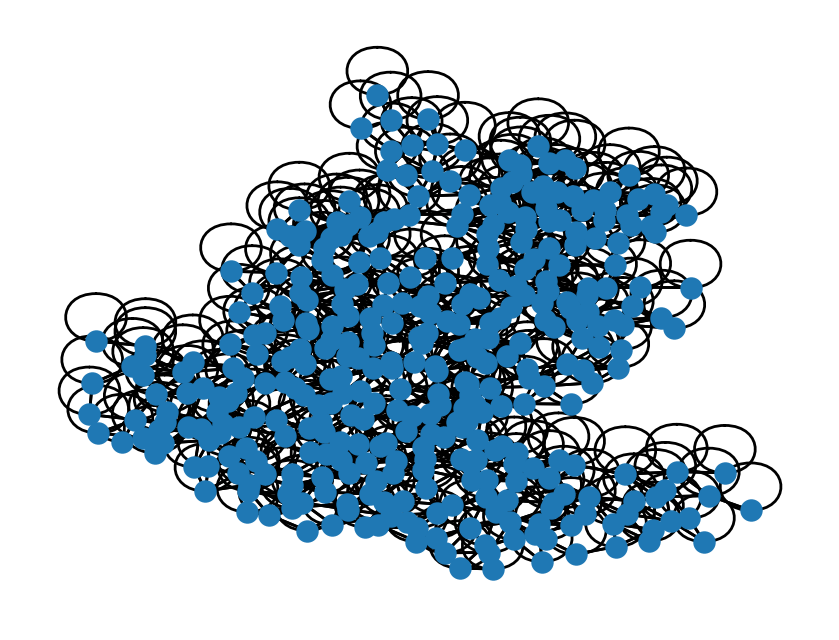

In [ ]:
nx_graph = dgl.to_networkx(first_graph)
plt.figure(figsize=(4, 3), dpi=200)
nx.draw(nx_graph, pos=nx.kamada_kawai_layout(nx_graph), node_size=50, arrows=False)
plt.show()

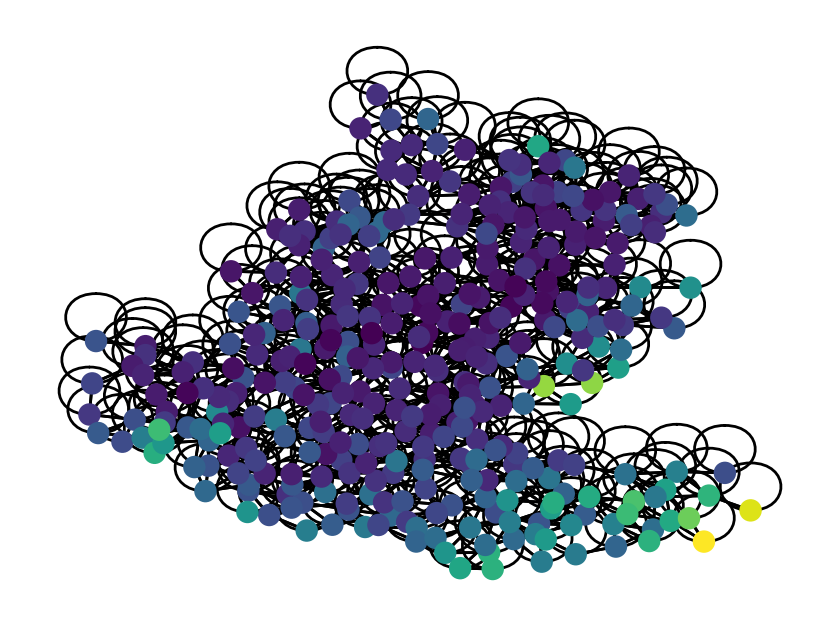

In [ ]:
nx_graph = dgl.to_networkx(first_graph, node_attrs=['b_factor'])
plt.figure(figsize=(4, 3), dpi=200)
nx.draw(nx_graph, pos=nx.kamada_kawai_layout(nx_graph), node_size=50, arrows=False, node_color=np.array([nx_graph.nodes[v]['b_factor'] for v in nx_graph]))
plt.show()